In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import jax.numpy as jnp

from utils import manifold, metrics, costs
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

from functools import partial

In [3]:
def preprocess(data):
    return data

file_name = "double_pendulum_1000_500_v0.5"
out_name = file_name
raw_data = np.load("data/" + file_name + ".npz")
raw_data, params = raw_data["data"], raw_data["params"]

E = params[:,0]
E1 = params[:,1]
E2 = params[:,2]

data = preprocess(raw_data)

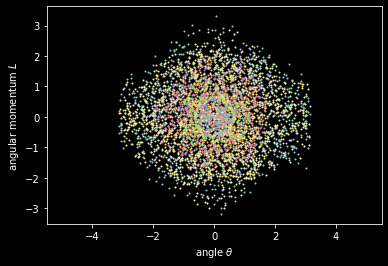

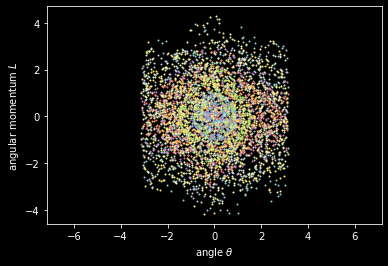

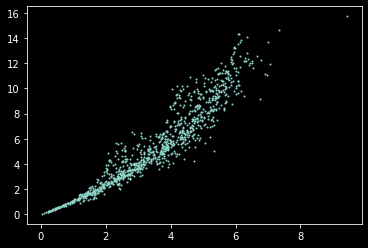

In [4]:
plt.figure()
for traj in raw_data[:10]:
    plt.scatter(traj[:,0], traj[:,1], s=1)
plt.xlabel(r"angle $\theta$")
plt.ylabel(r"angular momentum $L$")
plt.axis('equal')

plt.figure()
for traj in raw_data[:10]:
    plt.scatter(traj[:,2], traj[:,3], s=1)
plt.xlabel(r"angle $\theta$")
plt.ylabel(r"angular momentum $L$")
plt.axis('equal')

plt.figure()
plt.scatter(E+3, E1+E2, s=1);

Distance matrix: batch 1 of 25
Distance matrix: batch 2 of 25
Distance matrix: batch 3 of 25
Distance matrix: batch 4 of 25
Distance matrix: batch 5 of 25
Distance matrix: batch 6 of 25
Distance matrix: batch 7 of 25
Distance matrix: batch 8 of 25
Distance matrix: batch 9 of 25
Distance matrix: batch 10 of 25
Distance matrix: batch 11 of 25
Distance matrix: batch 12 of 25
Distance matrix: batch 13 of 25
Distance matrix: batch 14 of 25
Distance matrix: batch 15 of 25
Distance matrix: batch 16 of 25
Distance matrix: batch 17 of 25
Distance matrix: batch 18 of 25
Distance matrix: batch 19 of 25
Distance matrix: batch 20 of 25
Distance matrix: batch 21 of 25
Distance matrix: batch 22 of 25
Distance matrix: batch 23 of 25
Distance matrix: batch 24 of 25
Distance matrix: batch 25 of 25
Converged? True
[]


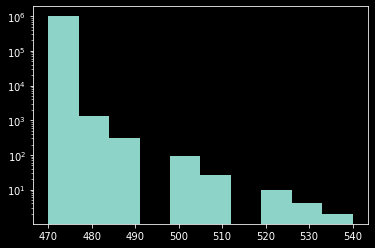

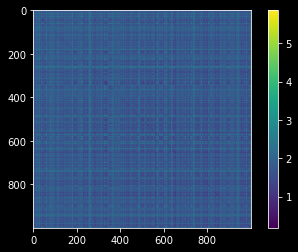

In [7]:
cost_fn = costs.PeriodicEuclidean(jnp.array([2*jnp.pi, jnp.inf, 2*jnp.pi, jnp.inf]))
metric = partial(metrics.wasserstein_metric, cost_fn=cost_fn)
dist_mat, converged, steps = metrics.distance_matrix(data, metric=metric, batch_size=200, mesh_shape=(4,2))

print("Converged?", jnp.all(converged))
print(np.stack(np.where(1-converged), axis=1))

plt.figure()
plt.hist([steps.reshape(-1)], log=True)
plt.figure()
plt.imshow(dist_mat)
plt.colorbar();

In [5]:
# np.savez(out_name + "_dist_mat.npz", dist_mat=dist_mat)
# dist_mat = np.load(out_name + "_dist_mat.npz")['dist_mat']

In [8]:
evals, embedding, epsilon = manifold.diffusion_map(dist_mat, n_components=20, epsilon='max', n_neighbors=50, alpha=1, robust=True)

nn_max = 2.854973139785277
epsilon = 16.301743257790804
mean_shift = 0.0012616680675447468


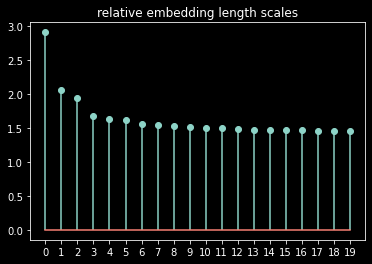

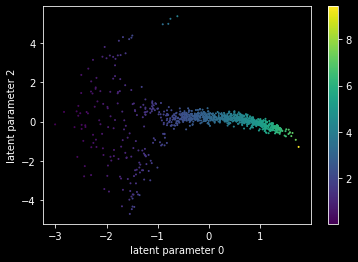

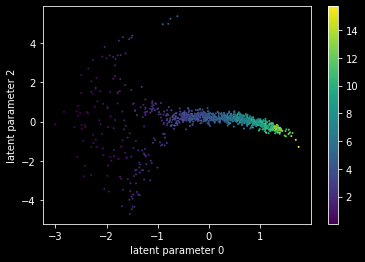

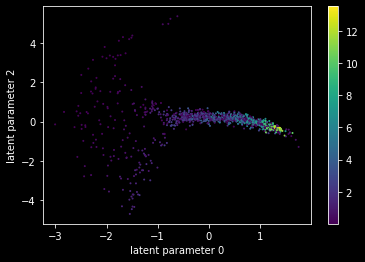

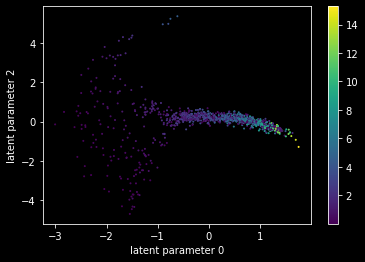

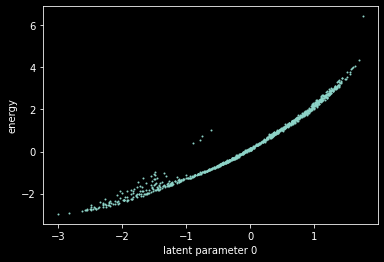

In [9]:
plt.figure()
# plt.stem(1/np.sqrt(-evals), use_line_collection=True)
plt.stem(np.sqrt(-epsilon/np.log(1+evals)), use_line_collection=True)
plt.title('relative embedding length scales')
plt.xticks(ticks=range(evals.shape[0]))

plt.figure()
plt.scatter(embedding[:,0], embedding[:,2], c=E+3, s=1)
plt.xlabel("latent parameter 0")
plt.ylabel("latent parameter 2")
plt.colorbar()

plt.figure()
plt.scatter(embedding[:,0], embedding[:,2], c=E1+E2, s=1)
plt.xlabel("latent parameter 0")
plt.ylabel("latent parameter 2")
plt.colorbar()

plt.figure()
plt.scatter(embedding[:,0], embedding[:,2], c=E1, s=1)
plt.xlabel("latent parameter 0")
plt.ylabel("latent parameter 2")
plt.colorbar()

plt.figure()
plt.scatter(embedding[:,0], embedding[:,2], c=E2, s=1)
plt.xlabel("latent parameter 0")
plt.ylabel("latent parameter 2")
plt.colorbar()

plt.figure()
plt.scatter(embedding[:,0], E, s=1)
plt.xlabel("latent parameter 0")
plt.ylabel("energy");

[264 684 860 866]
[-0.79176408 -0.90067152 -0.61450507 -0.75002306]


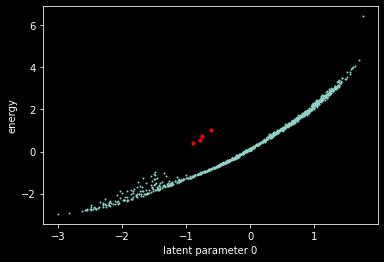

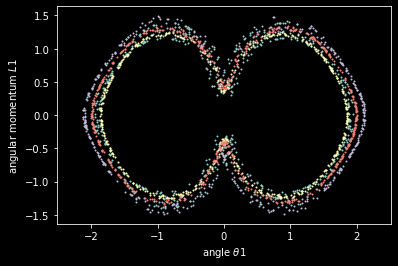

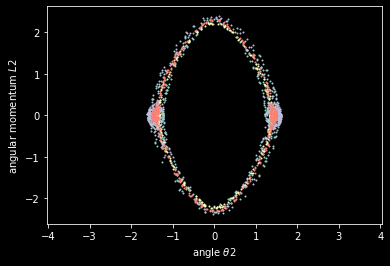

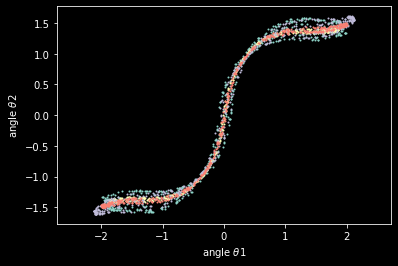

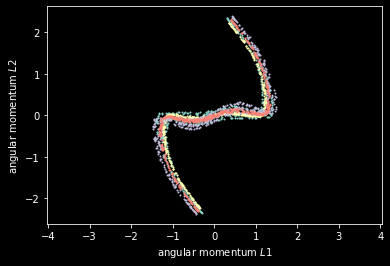

In [10]:
data_filter = (E>0) & (E<1.5) & (embedding[:,0]>-1) & (embedding[:,0]<-0.5)
print(np.where(data_filter)[0])
print(embedding[data_filter,0])

plt.figure()
plt.scatter(embedding[:,0], E, s=1)
plt.scatter(embedding[data_filter,0], E[data_filter], s=10, color='red')
plt.xlabel("latent parameter 0")
plt.ylabel("energy");

plt.figure()
for traj in data[data_filter]:
    plt.scatter(traj[:,0], traj[:,1], s=1)
plt.xlabel(r"angle $\theta$1")
plt.ylabel(r"angular momentum $L$1")
plt.axis('equal')

plt.figure()
for traj in data[data_filter]:
    plt.scatter(traj[:,2], traj[:,3], s=1)
plt.xlabel(r"angle $\theta$2")
plt.ylabel(r"angular momentum $L$2")
plt.axis('equal');

plt.figure()
for traj in data[data_filter]:
    plt.scatter(traj[:,0], traj[:,2], s=1)
plt.xlabel(r"angle $\theta$1")
plt.ylabel(r"angle $\theta$2")
plt.axis('equal');

plt.figure()
for traj in data[data_filter]:
    plt.scatter(traj[:,1], traj[:,3], s=1)
plt.xlabel(r"angular momentum $L$1")
plt.ylabel(r"angular momentum $L$2")
plt.axis('equal');

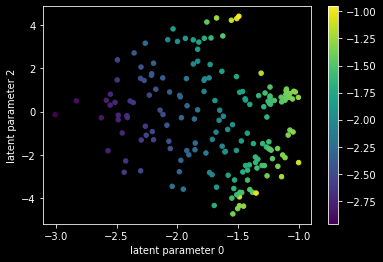

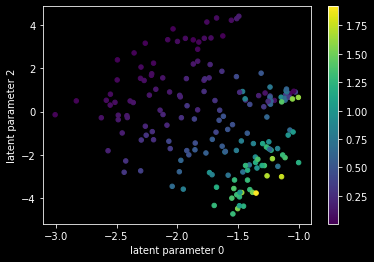

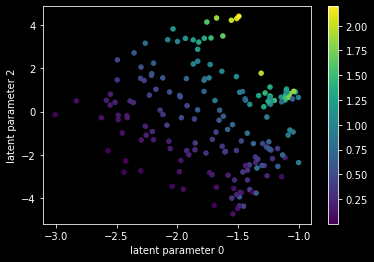

In [26]:
emb1 = 0
emb2 = 2
data_filter = embedding[:,0] < -1
s = 20

plt.figure()
plt.scatter(embedding[data_filter,emb1], embedding[data_filter,emb2], c=E[data_filter], s=s)
plt.xlabel(f"latent parameter {emb1}")
plt.ylabel(f"latent parameter {emb2}")
plt.colorbar()

plt.figure()
plt.scatter(embedding[data_filter,emb1], embedding[data_filter,emb2], c=E1[data_filter], s=s)
plt.xlabel(f"latent parameter {emb1}")
plt.ylabel(f"latent parameter {emb2}")
plt.colorbar()

plt.figure()
plt.scatter(embedding[data_filter,emb1], embedding[data_filter,emb2], c=E2[data_filter], s=s)
plt.xlabel(f"latent parameter {emb1}")
plt.ylabel(f"latent parameter {emb2}")
plt.colorbar()

[0]


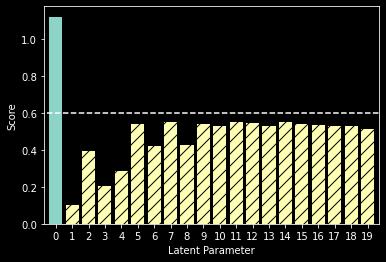

In [63]:
threshold = 0.6
n_components = evals.shape[0]

embed_list, scores_pass, scores_fail = manifold.heuristic_importance_score(evals, embedding, threshold=threshold, weights="adjusted")
print(embed_list)

plt.bar(list(range(n_components)), scores_pass)
plt.bar(list(range(n_components)), scores_fail, hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

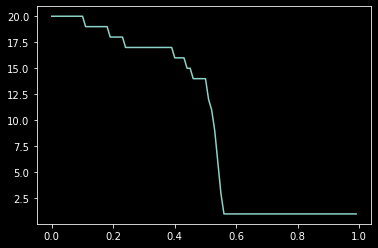

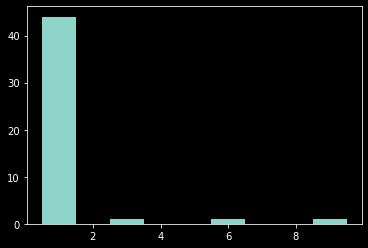

In [44]:
embedding_size_list = []
for thres in np.arange(0.0, 1., 0.01):
    embedding_size_list.append(len(manifold.heuristic_importance_score(evals, embedding, threshold=thres, weights="adjusted")[0]))

plt.figure()
plt.plot(np.arange(0.0, 1., 0.01), embedding_size_list)
plt.figure()
plt.hist(embedding_size_list, bins=np.arange(10)+0.5);

[0, 2]


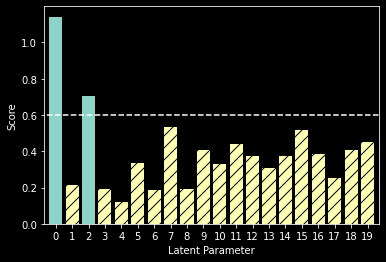

In [64]:
embedding2 = embedding[embedding[:,0] < -1,:]
embedding2 -= np.mean(embedding2, axis=0)
renorm = np.linalg.norm(embedding2, axis=0)/np.sqrt(embedding2.shape[0])
embedding2 /= renorm

threshold2 = 0.6
n_components = evals.shape[0]

embed_list2, scores_pass2, scores_fail2 = manifold.heuristic_importance_score(evals, embedding2, threshold=threshold2, weights="adjusted")
print(embed_list2)

plt.bar(list(range(n_components)), scores_pass2)
plt.bar(list(range(n_components)), scores_fail2, hatch='//')
plt.xticks(ticks=range(n_components))
plt.xlim(-0.7, n_components-0.3)
# plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Latent Parameter")
plt.hlines(threshold2, -1, n_components, 'white', linestyles='dashed');
# plt.savefig("unpredictability_scores.png", dpi=300)

R^2 = 0.7456486393063578
Coefficent(s): [-0.41547256  0.0705982 ]


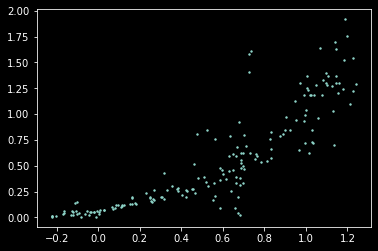

In [44]:
from sklearn.linear_model import LinearRegression
X = embedding2[:, embed_list2]
y = E1[embedding[:,0] < -1]
reg = LinearRegression().fit(X, y)
print("R^2 =", reg.score(X, y))
print("Coefficent(s):", reg.coef_)
plt.figure()
plt.scatter(reg.predict(X), y, s=2);

R^2 = 0.750756644155657
Coefficent(s): [ 0.52086321 -0.14490309]


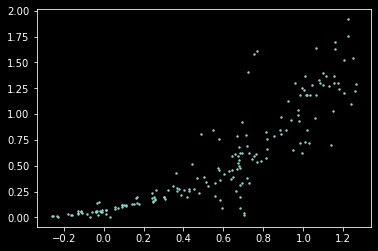

In [47]:
from sklearn.linear_model import LinearRegression
X = embedding[embedding[:,0] < -1, :][:, [0,2]]
y = E1[embedding[:,0] < -1]
reg = LinearRegression().fit(X, y)
print("R^2 =", reg.score(X, y))
print("Coefficent(s):", reg.coef_)
plt.figure()
plt.scatter(reg.predict(X), y, s=2);

double_pendulum_1000_500_v0.5


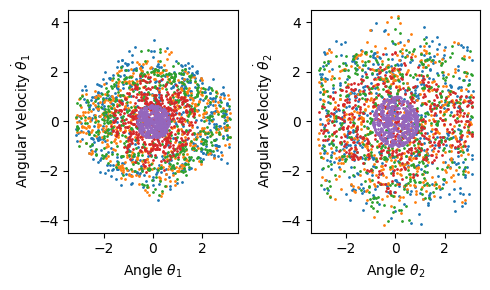

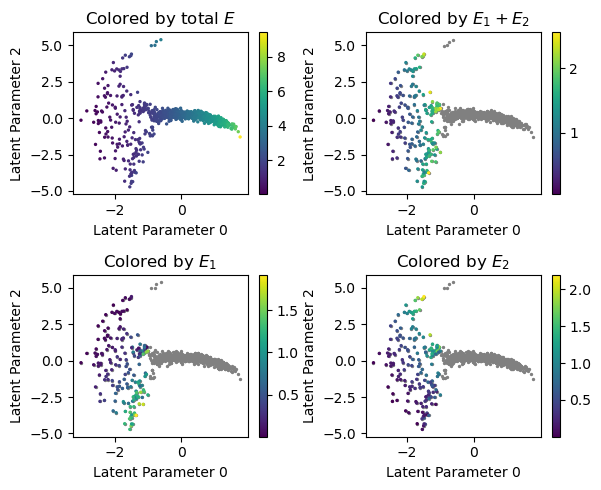

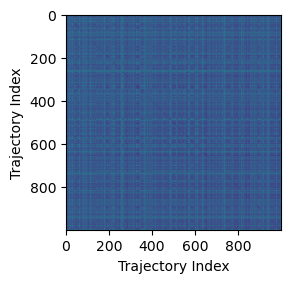

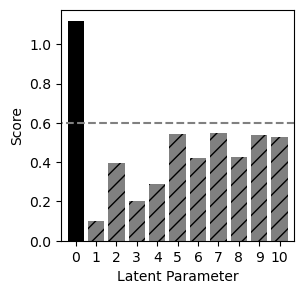

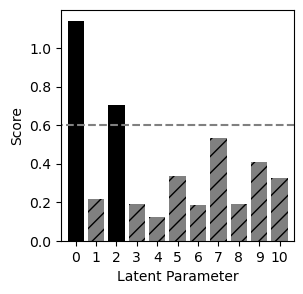

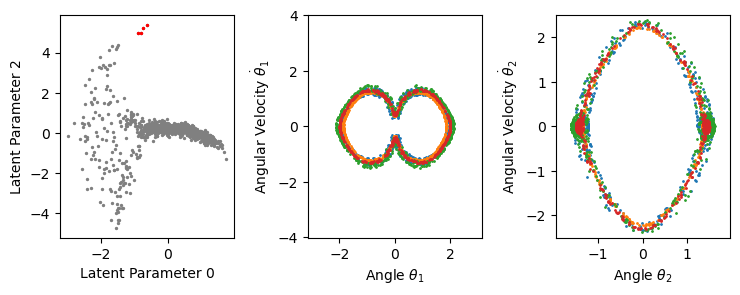

In [66]:
print(out_name)
with plt.style.context("default"):
    plt.figure(figsize=(5, 3))
    plt.subplot(121)
    for traj in raw_data[:5]:
        plt.scatter(traj[:,0], traj[:,1], s=1)
    plt.axis('equal')
    plt.xlim(-np.pi,np.pi)
    plt.ylim(-4.5, 4.5)
    plt.xlabel(r"Angle $\theta_1$")
    plt.ylabel(r"Angular Velocity $\dot\theta_1$")

    plt.subplot(122)
    for traj in raw_data[:5]:
        plt.scatter(traj[:,2], traj[:,3], s=1)
    plt.axis('equal')
    plt.xlim(-np.pi,np.pi)
    plt.ylim(-4.5, 4.5)
    plt.xlabel(r"Angle $\theta_2$")
    plt.ylabel(r"Angular Velocity $\dot\theta_2$")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_data.pdf", bbox_inches="tight")

    plt.figure(figsize=(6,5))
    plt.subplot(221)
    plt.scatter(embedding[:,0], embedding[:,2], c=E+3, s=2)
    plt.xlabel("Latent Parameter 0")
    plt.ylabel("Latent Parameter 2")
    plt.colorbar()
    plt.title("Colored by total $E$")
    # plt.axis('equal')

    plt.subplot(222)
    Eidx = embedding[:,0] < -1 #E < -2
    plt.scatter(embedding[:,0], embedding[:,2], c='gray', s=2)
    plt.scatter(embedding[Eidx,0], embedding[Eidx,2], c=(E1+E2)[Eidx], s=2)
    plt.colorbar()
    plt.xlabel("Latent Parameter 0")
    plt.ylabel("Latent Parameter 2")
    plt.title("Colored by $E_1 + E_2$")
    # plt.axis('equal')

    plt.subplot(223)
    plt.scatter(embedding[:,0], embedding[:,2], c='gray', s=2)
    plt.scatter(embedding[Eidx,0], embedding[Eidx,2], c=E1[Eidx], s=2)
    plt.colorbar()
    plt.xlabel("Latent Parameter 0")
    plt.ylabel("Latent Parameter 2")
    plt.title("Colored by $E_1$")
    # plt.axis('equal')

    plt.subplot(224)
    plt.scatter(embedding[:,0], embedding[:,2], c='gray', s=2)
    plt.scatter(embedding[Eidx,0], embedding[Eidx,2], c=E2[Eidx], s=2)
    plt.colorbar()
    plt.xlabel("Latent Parameter 0")
    plt.ylabel("Latent Parameter 2")
    plt.title("Colored by $E_2$")
    # plt.axis('equal')

    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_embedding.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    plt.imshow(dist_mat)
    plt.xlabel("Trajectory Index")
    plt.ylabel("Trajectory Index")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_dist_mat.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 11
    plt.bar(
        list(range(n_components)[:n_show_components]),
        scores_pass[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(n_components)[:n_show_components]),
        scores_fail[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(n_components)[:n_show_components])
    plt.xlim(-0.7, n_show_components - 0.3)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Latent Parameter")
    plt.hlines(threshold, -1, n_show_components, "gray", linestyles="dashed")
    plt.savefig(f"figures/{out_name}_score.pdf", bbox_inches="tight")

    plt.figure(figsize=(3, 3))
    n_show_components = 11
    plt.bar(
        list(range(n_components)[:n_show_components]),
        scores_pass2[:n_show_components],
        color="k",
    )
    plt.bar(
        list(range(n_components)[:n_show_components]),
        scores_fail2[:n_show_components],
        hatch="//",
        color="gray",
    )
    plt.xticks(ticks=range(n_components)[:n_show_components])
    plt.xlim(-0.7, n_show_components - 0.3)
    # plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xlabel("Latent Parameter")
    plt.hlines(threshold2, -1, n_show_components, "gray", linestyles="dashed")
    plt.savefig(f"figures/{out_name}_score2.pdf", bbox_inches="tight")

    plt.figure(figsize=(7.5, 3))
    plt.subplot(131)
    plt.scatter(embedding[:,0], embedding[:,2], c='gray', s=2)
    plt.scatter(embedding[embedding[:,2] > 4.5,0], embedding[embedding[:,2] > 4.5,2], c='r', s=2)
    # plt.gca().add_patch(plt.Circle((embedding[embedding[:,2] > 4.5,0].mean(), embedding[embedding[:,2] > 4.5,2].mean()), 0.5, color='k', fill=False))
    # plt.axis('off')
    plt.xlabel("Latent Parameter 0")
    plt.ylabel("Latent Parameter 2")
    # plt.axis('equal')

    plt.subplot(132)
    for traj in raw_data[embedding[:,2] > 4.5]:
        plt.scatter(traj[:,0], traj[:,1], s=1)
    plt.axis('equal')
    plt.xlim(-np.pi,np.pi)
    plt.ylim(-2.5, 2.5)
    plt.xlabel(r"Angle $\theta_1$")
    plt.ylabel(r"Angular Velocity $\dot\theta_1$")

    plt.subplot(133)
    for traj in raw_data[embedding[:,2] > 4.5]:
        plt.scatter(traj[:,2], traj[:,3], s=1)
    plt.axis('equal')
    plt.xlim(-np.pi,np.pi)
    plt.ylim(-2.5, 2.5)
    plt.xlabel(r"Angle $\theta_2$")
    plt.ylabel(r"Angular Velocity $\dot\theta_2$")
    plt.tight_layout()
    plt.savefig(f"figures/{out_name}_orbit.pdf", bbox_inches="tight")
